# Fuzzy c-Means Clustering for Persistence Diagrams and Riemannian Manifolds
##  _ICLR 2021 Geometric and Topological Learning Workshop_

## Introducation and Motivation

This submission is an implementation of Fuzzy c-Means clustering for persistence diagrams and Riemannian manifolds using Giotto-TDA and Geomstats, respectively. It is widely accepted that many real world problems are in fact fuzzy (Campbello, 2007); that is, datapoints can have partial membership to several clusters, rather than a single 'hard' labelling to only one cluster. We provide the ability to compute fuzzy clusters on persistence diagram space and Riemamanian manifolds using work we presented as a poster at the NeurIPS 2020 TDA and Beyond workshop (Davies et al., 2020). The goal of this submission is to extend the fields of computational geometry and topology by making an algorithm that is widely used in traditional ML (fuzzy clustering) available to practioners in the computational geometry and topology community.

To Giotto-TDA we add both hard and fuzzy clustering on persistence diagram space to the library, whereas for Geomstats we extend the hard clustering already present within the library to the fuzzy case. In the algorithm section we outline how the algorithm works, and highlight the convergence result from our previous work that gives the theoretical justification for extending fuzzy clustering to persistence diagram space and Riemannian manifolds. In the implementation section we discuss how we added fuzzy clustering to Giotto-TDA and GeomStats, highlighting key helper functions. In the experiments section we demonstrate fuzzy clustering on two simple datasets. We end by discussing the limitations of fuzzy clustering in persistence diagram space.

## Analysis - Algorithm and Implementation

### Algorithm

We alternatively update the cluster centres and values $r_{jk}$ which denote the degree to which datapoint $j$ is associated with cluster $k$. We use the standard formula for Euclidean FCM to update $r_{jk}$, which is given by 

$r_{jk} = \left( \sum_{l=1}^c \frac{ d(M_k, D_j) }{d(M_l, D_j)}  \right)^{-1}$,

where $c$ is the number of cluster centres (chosen as a hyperparameter), $M_k$ are the cluster centres, and $D_j$ are the data points (Bezdek, 1980). The distance $d$ is determined by the space we are in: for persistence diagrams we use the Wasserstein distance, and for Geomstats we use the distance on the space our points lie in.

To update the cluster centres we use the weighted Fréchet mean, which provides an analogue of barycentres for metric spaces. It is given by 

$M_k = \mathrm{arg}\min_{\hat{D} } \sum_{j=1}^n r_{jk}^2 W_2(\hat{D}, D_j)^2, \text{ for } k=1,\dots,c$.

For Giotto-TDA we provide an implementation of a modified version of Turner et al.'s (2012) algorithm for computing the non-weighted Fréchet mean in persistence diagram space. In Geomstats we use the function already present to compute the weighted Fréchet mean.

In Davies et al. (2020) we prove that every convergent subsequence of iterates of this FCM algorithm converges to a local minima or saddle point of the cost function
$J(R, M) = \sum_{j=1}^n \sum_{k=1}^c r_{jk}^2 d(M_k, D_j)^2.$
As that proof relies only on the definition of the weighted Fréchet mean it trivially extends to Riemannian manifolds, meaning we have the same convergence guarantees.



### Implementation

#### Giotto-TDA

We use Giotto-TDA to compute persistence diagrams that provide code to fuzzy cluster. The key function we implement is ```fpd_cluster```, which accepts a list of point datasets, the number of clusters, and the persistence diagram dimension, and returns cluster centres and membership values. It also optionally takes the maximum number of iterations to perform when clustering, which metric to use on persistence diagram space, an option to run the algorithm as hard clustering rather than fuzzy, and the option to evaluate the quality of the clusters with the fuzzy RAND index (Campbello, 2007), which we provide an implementation of. Another function we include is ```calc_frechet_mean```, which computes the weighted Fréchet mean of persistence diagrams using a weighted version of Turner et al.'s (2012) algorithm, and ```pd_fuzzy```, which accepts persistence diagrams to cluster.

We use Giotto-TDA's format for persistence diagrams throughout, including padding collections of diagrams with points with 0 birth and death values. We used SciPy's implementation of the Hungarian algorithm to efficiently compute optimal matchings. 

#### GeomStats

For Geomstats we modify the [RiemannianKMeans](https://github.com/geomstats/geomstats/blob/master/geomstats/learning/kmeans.py) class by adding a ```fuzzy``` boolean to the constructor which determines whether to compute hard or fuzzy clusters. If fuzzy is selected, then we can compute the membership values (or weights), as demonstrated below.

```
if self.fuzzy:
    dists[np.where(dists == 0)] = 0.00001
    weights = 1 / (dists * np.sum(1 / dists, axis=1)[:, None])
else:
    belongs = gs.argmin(dists, 1)
```

When updating the fuzzy cluster centres, we can use geomstats Fréchet mean function as follows.
```
mean = FrechetMean(metric=self.metric,
                   method=self.mean_method,
                   max_iter=150,
                   lr=self.lr,
                   point_type=self.point_type,)
mean.fit(X, weights=weights[:, i]) 
self.centroids[i] = mean.estimate_
```

Finally we update the ```predict``` function, allowing users to choose whether to select a hard label or fuzzy membership values when computing the predicted class of a point. The completed function is included in this submission as ```geomstats_fuzzycmeans.py```.

## Experiments - Fuzzy clustering demonstrations
### Giotto-TDA demo

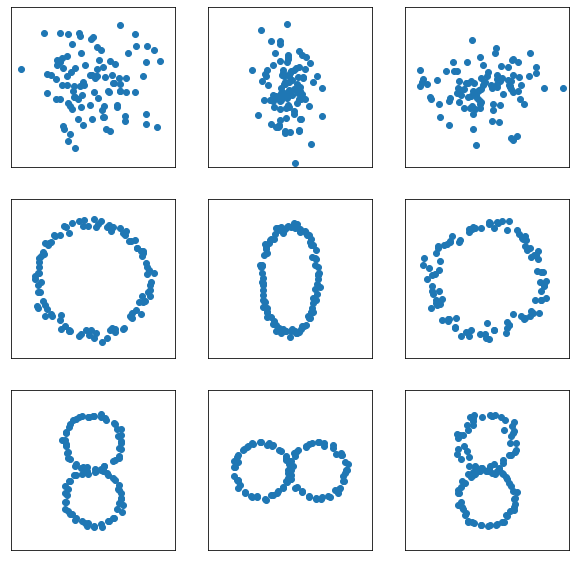

In [1]:
from synthetic_data import gen_data2, plot_dataset, plot_three_clusters
import giotto_fcm

# Generate synthetic dataset
synthetic_data = gen_data2(seed=0, noise=0.05, n_samples=100)

# Plot synthetic dataset
plot_dataset(synthetic_data)

In [2]:
# Pass the datasets to the clustering

num_clusters = 3
homology_dimension = 1
r, M = giotto_fcm.fpd_cluster(synthetic_data, num_clusters, homology_dimension, max_iter=20, verbose=True)

Fuzzy iteration: 0
 -- Update r -- 
   J(r, M) = 1.6739360115751167
 -- Update M -- 
      Frechet iterations for M_0: 3
      Frechet iterations for M_1: 4
      Frechet iterations for M_2: 3
   J(r, M) = 1.2049974936505616

Fuzzy iteration: 1
 -- Update r -- 
   J(r, M) = 1.2421364715548062
 -- Update M -- 
      Frechet iterations for M_0: 4
      Frechet iterations for M_1: 3
      Frechet iterations for M_2: 4
   J(r, M) = 1.2165071113003423

Fuzzy iteration: 2
 -- Update r -- 
   J(r, M) = 1.23728444716614
 -- Update M -- 
      Frechet iterations for M_0: 4
      Frechet iterations for M_1: 3
      Frechet iterations for M_2: 4
   J(r, M) = 1.2311514826843593

Fuzzy iteration: 3
 -- Update r -- 
   J(r, M) = 1.2415204006686626
 -- Update M -- 
      Frechet iterations for M_0: 4
      Frechet iterations for M_1: 3
      Frechet iterations for M_2: 4
   J(r, M) = 1.239387620284945

Fuzzy iteration: 4
 -- Update r -- 
   J(r, M) = 1.2445150437246764
 -- Update M -- 
      Frechet 

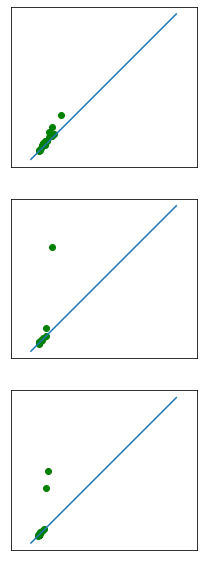

In [3]:
# Plot the resulting clusters
# The clusters have zero, one, or two significant off-diagonal points, corresponding to 
#     zero, one, or two holes in the datasets
plot_three_clusters(M)

### GeomStats Demo

Following the [geomstat docs](https://geomstats.github.io/notebooks/05_riemannian_kmeans.html), we cluster points on the sphere. However, we run our fuzzy clustering algorithm, leading to fuzzy membership values. These give additional information that can be exploited for datasets with an underlying fuzzy structure.

INFO: Using numpy backend
INFO: Convergence reached after 12 iterations


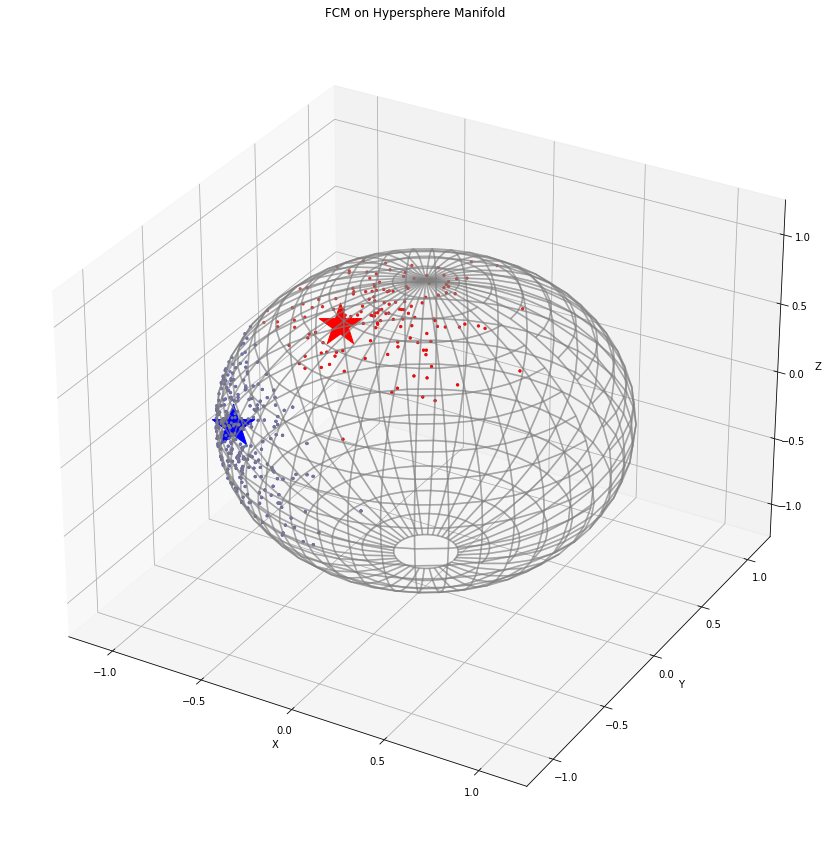

In [4]:
# Import packages

import matplotlib.pyplot as plt
import numpy as np

import geomstats.backend as gs
import geomstats.visualization as visualization
from geomstats.geometry.hypersphere import Hypersphere
from geomstats.geometry.special_orthogonal import SpecialOrthogonal

np.random.seed(1)
gs.random.seed(1000)

# initiate datapoints on a hypersphere

sphere = Hypersphere(dim=2)
cluster = sphere.random_von_mises_fisher(kappa=20, n_samples=140)

SO3 = SpecialOrthogonal(3)
rotation1 = SO3.random_uniform()
rotation2 = SO3.random_uniform()
rotation3 = SO3.random_uniform()

cluster_1 = cluster @ rotation1
cluster_2 = cluster @ rotation2
cluster_3 = cluster @ rotation3

# run fuzzy c-means clustering

from geomstats_fuzzycmeans import RiemannianKMeans
from geomstats.geometry.hypersphere import Hypersphere

manifold = Hypersphere(dim=2)
metric = manifold.metric

data = gs.concatenate((cluster_1, cluster_2, cluster_3), axis=0)

kmeans = RiemannianKMeans(metric, 2, tol=1e-3, verbose=True, fuzzy=True)
kmeans.fit(data)
labels = kmeans.predict(data)
centroids = kmeans.centroids


# plot the results

fig = plt.figure(figsize=(15, 15))
colors = ['red', 'blue']

ax = visualization.plot(
    data,
    space='S2',
    marker='.',
    color='grey')

for i in range(2):
    ax = visualization.plot(
        points=data[labels == i],
        ax=ax,
        space='S2',
        marker='.',
        color=colors[i])

for i, c in enumerate(centroids):
    ax = visualization.plot(
        c,
        ax=ax,
        space='S2',
        marker='*',
        s=2000,
        color=colors[i])

ax.set_title('FCM on Hypersphere Manifold');
ax.auto_scale_xyz([-1, 1], [-1, 1], [-1, 1])

plt.show()

In [5]:
# An example of the fuzzy membership values. 
# Rather than a single label, each point has probabilistic membership values to each cluster centre

fuzzy_labels = kmeans.predict(data, fuzzy_predictions=True)
print(fuzzy_labels[0:5])

[[0.74676725 0.25323275]
 [0.36730915 0.63269085]
 [0.78066131 0.21933869]
 [0.73677871 0.26322129]
 [0.73269577 0.26730423]]


## Limitations and Perspectives

Although we are the first to provide fuzzy clustering in persistence diagram space, a primary limitation of our approach is that one can embed persistence diagrams into Euclidean space using any number of techniques that are provided in Giotto-TDA, and fuzzy cluster those vectors. However, when we presented our work as a poster at the TDA & Beyond NeurIPS 2020 workshop, we had a number of people approach us who were interested in using our work, so we hope including it as part of Giotto-TDA will make it more accessible.

It is widely accepted that many real world problems are naturally fuzzy (Campbello, 2007). Therefore the ability to process datasets in an unsupervised way using persistence diagrams (with Giotto-TDA) and on Riemannian manifolds (with GeomStats) can provide additional insight into many problems practioners in computational geometry and topology face.

## References

Bezdek, J. C.   **A convergence theorem for the fuzzy iso-data clustering algorithms. IEEE Transactions on Pattern Analysis and Machine Intelligence**, PAMI-2(1):1–8, Jan 1980.

Campello, R. J.,  **A fuzzy extension of the rand index andother related indexes for clustering and classification assessment. Pattern Recognition Letters**, 28(7):833–841, 2007

Davies, T., Aspinall, J., Wilder, B., Tran-Thanh, L., **Fuzzy c-means clustering for persistence diagrams**. arXiv:2006.02796, TDA and Beyond workshop at NeurIPS 2020

Turner, K., Mileyko, Y., Mukherjee, S., and Harer, J. **Fréchet means for distributions of persistence diagrams.** Discrete & Computational Geometry, 52:44–70, 2012